In [5]:
import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt

from utils import printf, load_data
from models import SimpleSNN
import snntorch as snn

# device = torch.device('mps')
device = torch.device('cpu')

In [2]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(0,1)
])

batch_size = 256

train_dataset, train_loader = load_data('cifar', path='../data', batch_size=batch_size)
test_dataset, test_loader = load_data('cifar', path='../data', batch_size=batch_size, train=False)

Files already downloaded and verified
Files already downloaded and verified


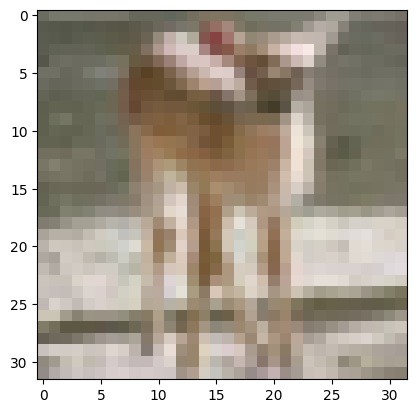

In [3]:
features, labels = next(iter(train_loader))
plt.imshow(features[0].permute(1,2,0))
plt.show()

# Training

In [4]:
model = SimpleSNN(3*32*32, num_steps=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

n_epochs = 10
for epoch in range(n_epochs):
    n_correct, n_total = 0., 0.
    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)
        output = model(features)
        loss = criterion(output, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        n_correct += (output.argmax(dim=-1) == labels).sum().item()
        n_total += len(labels)
    print(n_correct / n_total)

0.11142
0.21462
0.26638
0.30184
0.32466
0.33432
0.34412
0.35312
0.36168
0.37754


# Evaluation

In [ ]:
with torch.no_grad():
    n_correct, n_total = 0., 0.
    for features, labels in test_loader:
        output = model(features)
        

        n_correct += (output.argmax(dim=-1) == labels).sum().item()
        n_total += len(labels)
    print(n_correct / n_total)

0.9701


# Attacks

In [ ]:
def fgsm_attack(model, loss_fn, images, labels, epsilon):
    '''Fast Gradient Sign Method'''
    images.requires_grad = True
    outputs = model(images)
    loss = loss_fn(outputs, labels)
    loss.backward()
    image_gradients = images.grad.data
    perturbed_image = images + epsilon * image_gradients.sign()
    perturbed_image = torch.clamp(perturbed_image, -1, 1)
    output = model(perturbed_image)
    return perturbed_image, output.argmax(dim = -1)

In [ ]:
features, labels = next(iter(train_loader))
features, labels = features.to(device), labels.to(device)
perturbed, perturbed_output = fgsm_attack(model, nn.CrossEntropyLoss(), features, labels, epsilon=0.01)

In [ ]:
model.eval()
predictions_on_perturbed = model(perturbed).argmax(dim=1)
predictions_on_originals = model(features).argmax(dim=1)

(predictions_on_perturbed != predictions_on_originals).nonzero().view(-1)

tensor([  6,  25,  34,  39,  55, 100, 101, 118, 146, 158, 226, 241])

Text(0.5, 1.0, 'Prediction: 9')

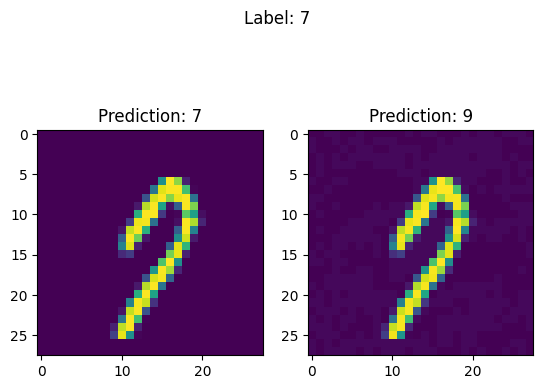

In [ ]:
index = 6

fig, axs = plt.subplots(1,2)
axs[0].imshow(features[index, 0].detach().cpu())
axs[1].imshow(perturbed[index, 0].detach().cpu())
fig.suptitle(f'Label: {labels[index]}')
axs[0].set_title(f'Prediction: {predictions_on_originals[index]}')
axs[1].set_title(f'Prediction: {predictions_on_perturbed[index]}')